## Problem 1
### Question 1
<span style="color: blue;">Explain the terms co-adaptation and internal covariance-shift. Use examples if needed.</span>

#### Co-adaptation
<br />
<div style="width: 700px; word-wrap: break-word;"><p style="text-align:justify">Co-adaptation refers to the phenomenon where multiple neurons in a neural network learn to capture redundant features from the input data, thereby becoming overly reliant on each other's behavior. As a result, these neurons lose their individual capacity to contribute uniquely to the learning process, making the network less efficient and more susceptible to overfitting. Co-adaptation often occurs when some neurons dominate the learning process by having large weights or gradients, causing other neurons to adapt their behavior to compensate for the dominant neurons. This interdependence between neurons limits the network's capacity to generalize well on unseen data.</p>
<p style="text-align:justify">One technique to mitigate co-adaptation is dropout, a regularization method that randomly "drops" (sets to zero) a proportion of neurons during training. By temporarily removing some neurons, dropout forces the remaining neurons to learn more robust and independent representations, reducing their reliance on each other and improving the network's generalization performance.</p></div>

#### Internal Covariance Shift
<br />
<div style="width: 700px; word-wrap: break-word;"><p style="text-align:justify">Internal covariance shift refers to the change in the distribution of activations in the hidden layers of a deep neural network during training. As the weights of the network are updated through backpropagation, the input distribution of each hidden layer shifts, causing the subsequent layers to adapt to the new distribution continuously. This phenomenon can slow down the training process and make it difficult for the network to converge.</p>
<p style="text-align:justify">Batch normalization is a technique proposed to alleviate the internal covariance shift. It normalizes the input distribution for each hidden layer by standardizing the activations (i.e., making their mean 0 and standard deviation 1) and applying learnable scaling and shifting parameters. By normalizing the activations, batch normalization reduces the internal covariance shift, allowing for higher learning rates and faster convergence. Additionally, batch normalization can have a regularizing effect, reducing the risk of overfitting.</p></div>

## Problem 1
### Question 2
<span style="color: blue;">Train LeNet-5 with standard normalization of input and batch normalization for hidden layers.</span>

> Install torch on the compute node, in case it is not present

In [1]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


> Install other packages 

In [2]:
!pip install tqdm seaborn torchvision

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


> Check box information like current user, hostname, processor, RAM and GPU to ensure everything is fine.

In [3]:
!whoami

vgn2004


In [4]:
!echo "Hostname: $(hostname)"

Hostname: gr008.hpc.nyu.edu


In [5]:
!echo "Processor: $(lscpu | grep 'Model name' | awk -F ':' '{print $2}' | xargs)"

Processor: Intel(R) Xeon(R) Platinum 8268 CPU @ 2.90GHz


In [6]:
!echo "RAM: $(free -h | grep Mem: | awk '{print $4}')"

RAM: 164Gi


In [7]:
!nvidia-smi

Tue Mar 28 07:33:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:2F:00.0 Off |                    0 |
| N/A   34C    P0    51W / 250W |      0MiB / 46080MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

> Check if the above GPU is being interfaced with by torch library

In [8]:
import torch
torch.cuda.is_available()

True

> Confirm number of GPUs available

In [9]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

> Import libraries

- Pickle: Useful for saving models
- Tqdm: Provides a loading bar for for-loops, useful for tracking progress during an epoch
- Numpy, Pandas: Standard data manipulation libraries
- Matplotlib, Seaborn: Standard data visualization libraries
- Torch.nn: Useful for defining neural net layers

In [10]:
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

> Choose available device for training (cuda or cpu)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

> Store commonly changing model configurations in an object for easy tracking

In [12]:
class ModelConfig:
    def __init__(self, num_epochs=10, learning_rate=0.001, optimizer=optim.Adam, criterion=nn.CrossEntropyLoss):
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.criterion = criterion    

> Create utility functions to help with computing mean and standard deviation of a dataset, fetching learned parameters of the batch normalization layers and creating violin plots.

In [13]:
def compute_mean_std(dataset):
    mean = 0.0
    std = 0.0
    for data, _ in dataset:
        mean += data.mean()
        std += data.std()
    mean /= len(dataset)
    std /= len(dataset)
    return mean.item(), std.item()

def get_bn_params(model):
    bn_params = {}
    for name, layer in model.named_modules():
        if isinstance(layer, nn.BatchNorm2d):
            bn_params[name] = {
                'weight': layer.weight.detach().cpu().numpy(),
                'bias': layer.bias.detach().cpu().numpy()
            }
    return bn_params

def create_violin_plots(bn_params):
    data = []
    for layer_name, params in bn_params.items():
        for param_name, values in params.items():
            for value in values:
                data.append({
                    'Layer': layer_name,
                    'Parameter': param_name,
                    'Value': value
                })
    df = pd.DataFrame(data)
    sns.violinplot(x='Layer', y='Value', hue='Parameter', data=df, split=True, inner='quartile')
    plt.show()

> Define functions that will the train or evaluate loop for a particular dataset and model. Note that the training loops allows for schedulers to ensure that we can use the same function for Problem 2 as well.

In [14]:
def train(data_loader, model, criterion, optimizer, scheduler = None, early_stop=None):
    learning_rate_tracker = {}
    epoch_correct = 0
    running_loss = 0.0
    model.train()
    for i, (images, labels) in tqdm(enumerate(data_loader)):
        learning_rate_tracker[i] = optimizer.param_groups[0]['lr']
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()
        predicted = torch.max(outputs.data, 1)[1]
        epoch_correct += (predicted == labels).sum().item()
        
        if early_stop and i==early_stop:
            break
            
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

    
    return epoch_correct , running_loss, learning_rate_tracker
    
    
def evaluate(data_loader, model, criterion):
    epoch_correct = 0
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) 
            running_loss += loss.item()
            predicted = torch.max(outputs.data, 1)[1]
            epoch_correct += (predicted == labels).sum().item()
    
    return epoch_correct, running_loss

> Load data using only the ToTensor() transform. We will handle input data normalization later

In [15]:
batch_size=64

train_dataset_pre_normalize = datasets.MNIST(root='data/', train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)

test_dataset_pre_normalize = datasets.MNIST(root='data/', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)

train_loader_pre_normalize = torch.utils.data.DataLoader(dataset=train_dataset_pre_normalize, batch_size=batch_size, shuffle=True)

test_loader_pre_normalize = torch.utils.data.DataLoader(dataset=test_dataset_pre_normalize, batch_size=batch_size, 
shuffle=True)

> Compute mean and standard deviation for MNIST trianing dataset

In [16]:
mean, std = compute_mean_std(train_dataset_pre_normalize)
f"Mean: {mean:.3f}, Std: {std:.3f}"

'Mean: 0.131, Std: 0.302'

> Normalize the dataset using the calculated mean and standard deviation, then create data loaders

In [17]:
transform_with_normalize = transforms.Compose([transforms.ToTensor(),transforms.Normalize((mean,), (std,))])

train_dataset_post_normalize = datasets.MNIST(root='data/', train=True, transform=transform_with_normalize, download=True)

test_dataset_post_normalize = datasets.MNIST(root='data/', train=False, transform=transform_with_normalize, download=True)

train_loader_post_normalize = torch.utils.data.DataLoader(dataset=train_dataset_post_normalize, batch_size=batch_size, shuffle=True)

test_loader_post_normalize = torch.utils.data.DataLoader(dataset=test_dataset_post_normalize, batch_size=batch_size, shuffle=True)

> LeNet Architecture. Include booleans to allow for addition of batch norm and dropout, so that we can handle parts 4 and 5 of problem 1 elegantly

In [18]:
class LeNet5(nn.Module):
    def __init__(self, has_input_batch_norm=False, has_dropout=False):
        super(LeNet5, self).__init__()
        
        self.has_input_batch_norm = has_input_batch_norm
        self.has_dropout = has_dropout
        
        if self.has_dropout:
            self.dropout0 = nn.Dropout2d(0.2)
            
        if self.has_input_batch_norm:
            self.bn0 = nn.BatchNorm2d(1)
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        if self.has_dropout:
            self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        if self.has_input_batch_norm:
            x = self.bn0(x)
        if self.has_dropout:
            x = self.dropout0(x)
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        
        
        if self.has_dropout:
            x = self.dropout1(x)
        x = F.relu(self.fc1(x))    
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

> Train over 10 epochs using Adam optimizer, without input batch norm and dropout, but with standard normalization. Save the model with best test accuracy.

In [19]:
model_config = ModelConfig()
model_q2 = LeNet5().to(device)
optimizer = model_config.optimizer(model_q2.parameters(), lr=model_config.learning_rate)
criterion = model_config.criterion()

num_samples = len(train_loader_post_normalize.dataset)
num_batches = len(train_loader_post_normalize)
    
best_accuracy = 0.0
for epoch in range(1,model_config.num_epochs+1):
    print(f"Epoch: ({epoch}/{model_config.num_epochs})")

    training_correct, training_loss, _ = train(data_loader = train_loader_post_normalize,
                                             model=model_q2, 
                                             criterion=criterion, 
                                             optimizer=optimizer)
    training_loss = training_loss/num_batches
    training_accuracy = training_correct/num_samples
    print(f"Training Accuracy: {training_accuracy * 100:.2f}%, Training Loss: {training_loss}")

    validation_correct, validation_loss = evaluate(data_loader = train_loader_post_normalize, model=model_q2, criterion=criterion)
    validation_loss = validation_loss/num_batches
    validation_accuracy = validation_correct/num_samples
    print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%, Validation Loss: {validation_loss}")
    
    test_correct, test_loss = evaluate(data_loader = test_loader_post_normalize, model=model_q2, criterion=criterion)
    test_loss = test_loss/len(test_loader_post_normalize)
    test_accuracy = test_correct/len(test_loader_post_normalize.dataset)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model_q2.state_dict(), "model_q2.pt")
        
print(f"\n\nBest Test Accuracy: {best_accuracy * 100:.2f}%")

Epoch: (1/10)


938it [00:14, 66.71it/s]


Training Accuracy: 94.77%, Training Loss: 0.1841541302245436
Validation Accuracy: 97.90%, Validation Loss: 0.0703389523843768
Test Accuracy: 98.02%, Test Loss: 0.06505333566682259
Epoch: (2/10)


938it [00:12, 75.75it/s]


Training Accuracy: 98.15%, Training Loss: 0.05903478448568627
Validation Accuracy: 98.45%, Validation Loss: 0.05016697545822309
Test Accuracy: 98.28%, Test Loss: 0.0551766776242501
Epoch: (3/10)


938it [00:12, 74.68it/s]


Training Accuracy: 98.62%, Training Loss: 0.044449803440137575
Validation Accuracy: 98.79%, Validation Loss: 0.03814245187902082
Test Accuracy: 98.47%, Test Loss: 0.04601950428981014
Epoch: (4/10)


938it [00:12, 75.38it/s]


Training Accuracy: 98.91%, Training Loss: 0.03548296938159082
Validation Accuracy: 99.04%, Validation Loss: 0.029864504607878366
Test Accuracy: 98.89%, Test Loss: 0.03552752648810945
Epoch: (5/10)


938it [00:12, 75.42it/s]


Training Accuracy: 99.01%, Training Loss: 0.030789925711201396
Validation Accuracy: 99.25%, Validation Loss: 0.02339120068550626
Test Accuracy: 98.81%, Test Loss: 0.03481863134011929
Epoch: (6/10)


938it [00:12, 75.45it/s]


Training Accuracy: 99.13%, Training Loss: 0.026173009648750935
Validation Accuracy: 99.37%, Validation Loss: 0.020017272834085238
Test Accuracy: 98.77%, Test Loss: 0.034494104250712365
Epoch: (7/10)


938it [00:12, 75.00it/s]


Training Accuracy: 99.29%, Training Loss: 0.021696593685672984
Validation Accuracy: 99.37%, Validation Loss: 0.018888347857389853
Test Accuracy: 99.02%, Test Loss: 0.03420733135830534
Epoch: (8/10)


938it [00:12, 75.26it/s]


Training Accuracy: 99.35%, Training Loss: 0.019907260868534348
Validation Accuracy: 99.43%, Validation Loss: 0.017240076509400466
Test Accuracy: 98.87%, Test Loss: 0.03554422079432002
Epoch: (9/10)


938it [00:12, 75.26it/s]


Training Accuracy: 99.42%, Training Loss: 0.017865732317073776
Validation Accuracy: 99.27%, Validation Loss: 0.021061552305289333
Test Accuracy: 98.75%, Test Loss: 0.04270146191807888
Epoch: (10/10)


938it [00:12, 75.87it/s]


Training Accuracy: 99.55%, Training Loss: 0.014786466272547654
Validation Accuracy: 99.68%, Validation Loss: 0.009471515024167347
Test Accuracy: 99.07%, Test Loss: 0.03159871137781891


Best Test Accuracy: 99.07%


<span style="color: blue;">What are the learned batch norm parameters for each layer?</span>
> Display batch norm parameters of best performing model

In [20]:
best_model_q2 = LeNet5().to(device)
best_model_q2.load_state_dict(torch.load('model_q2.pt'))
bn_params = get_bn_params(best_model_q2)
bn_params

{'bn1': {'weight': array([1.1783487 , 0.8993236 , 1.011529  , 0.86795205, 0.8759164 ,
         1.1181725 ], dtype=float32),
  'bias': array([-0.14377844, -0.27907577, -0.4010887 , -0.1045674 , -0.218388  ,
         -0.02171147], dtype=float32)},
 'bn2': {'weight': array([1.1544764, 1.0742028, 0.9533552, 1.1339399, 1.099353 , 1.0336896,
         1.1586052, 1.2453828, 1.1750015, 1.0520625, 1.1637381, 1.2307543,
         1.0624565, 1.1124377, 1.0248461, 1.0594606], dtype=float32),
  'bias': array([-0.17634948, -0.33709148, -0.21682018, -0.2575717 , -0.29878923,
         -0.23952906, -0.12922308, -0.221531  , -0.31851035, -0.17422967,
         -0.32097363, -0.21304354, -0.17139429, -0.21684048, -0.30944526,
         -0.25864315], dtype=float32)}}

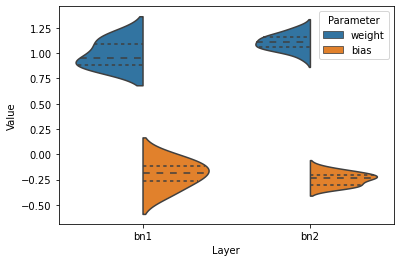

In [21]:
create_violin_plots(bn_params)

## Problem 1
### Question 3
<span style="color:blue">Next instead of standard normalization use batch normalization for the input layer also and train the
network.</span>

> Train model for  10 epochs using Adam optimizer, add has_input_batch_norm=True while creating the model so that the input layer first goes through a batch norm layer

In [22]:
model_config = ModelConfig()
model_q3 = LeNet5(has_input_batch_norm=True).to(device)
optimizer = model_config.optimizer(model_q3.parameters(), lr=model_config.learning_rate)
criterion = model_config.criterion()
    
best_accuracy = 0.0
for epoch in range(1,model_config.num_epochs+1):
    print(f"Epoch: ({epoch}/{model_config.num_epochs})")

    training_correct, training_loss, _ = train(data_loader = train_loader_pre_normalize, model=model_q3, criterion=criterion, optimizer=optimizer)
    training_loss = training_loss/num_batches
    training_accuracy = training_correct/num_samples
    print(f"Training Accuracy: {training_accuracy * 100:.2f}%, Training Loss: {training_loss}")

    validation_correct, validation_loss = evaluate(data_loader = train_loader_pre_normalize, model=model_q3, criterion=criterion)
    validation_loss = validation_loss/num_batches
    validation_accuracy = validation_correct/num_samples
    print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%, Validation Loss: {validation_loss}")

    test_correct, test_loss = evaluate(data_loader = test_loader_pre_normalize, model=model_q3, criterion=criterion)
    test_loss = test_loss/len(test_loader_pre_normalize)
    test_accuracy = test_correct/len(test_loader_pre_normalize.dataset)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model_q3.state_dict(), "model_q3.pt")
        
print(f"\n\nBest Test Accuracy: {best_accuracy * 100:.2f}%")

Epoch: (1/10)


938it [00:07, 126.93it/s]


Training Accuracy: 94.83%, Training Loss: 0.17949683716578255
Validation Accuracy: 98.22%, Validation Loss: 0.058134106420743056
Test Accuracy: 98.10%, Test Loss: 0.05674317683342393
Epoch: (2/10)


938it [00:07, 127.63it/s]


Training Accuracy: 98.19%, Training Loss: 0.057528676341291766
Validation Accuracy: 98.70%, Validation Loss: 0.041459930010824035
Test Accuracy: 98.51%, Test Loss: 0.04549453748467194
Epoch: (3/10)


938it [00:07, 128.02it/s]


Training Accuracy: 98.55%, Training Loss: 0.04509353274505572
Validation Accuracy: 99.02%, Validation Loss: 0.03077078818276312
Test Accuracy: 98.69%, Test Loss: 0.03484095653161632
Epoch: (4/10)


938it [00:07, 128.79it/s]


Training Accuracy: 98.84%, Training Loss: 0.03546310040259189
Validation Accuracy: 99.10%, Validation Loss: 0.02854736948083999
Test Accuracy: 98.71%, Test Loss: 0.038399106510366154
Epoch: (5/10)


938it [00:07, 127.37it/s]


Training Accuracy: 99.01%, Training Loss: 0.029631990438858013
Validation Accuracy: 99.18%, Validation Loss: 0.025007019061528184
Test Accuracy: 98.82%, Test Loss: 0.03314868135490472
Epoch: (6/10)


938it [00:07, 129.45it/s]


Training Accuracy: 99.11%, Training Loss: 0.026959259557305153
Validation Accuracy: 99.06%, Validation Loss: 0.028744737636412124
Test Accuracy: 98.74%, Test Loss: 0.039560898733221495
Epoch: (7/10)


938it [00:07, 127.78it/s]


Training Accuracy: 99.30%, Training Loss: 0.022507569990490677
Validation Accuracy: 99.60%, Validation Loss: 0.012998416804877516
Test Accuracy: 99.05%, Test Loss: 0.03082176680173532
Epoch: (8/10)


938it [00:07, 128.13it/s]


Training Accuracy: 99.28%, Training Loss: 0.02154760638996934
Validation Accuracy: 99.46%, Validation Loss: 0.015040462402385043
Test Accuracy: 99.07%, Test Loss: 0.031752772766406444
Epoch: (9/10)


938it [00:07, 127.38it/s]


Training Accuracy: 99.42%, Training Loss: 0.017932572181989462
Validation Accuracy: 99.17%, Validation Loss: 0.026665957525079234
Test Accuracy: 98.87%, Test Loss: 0.037263192985569064
Epoch: (10/10)


938it [00:07, 127.75it/s]


Training Accuracy: 99.42%, Training Loss: 0.017269778785063295
Validation Accuracy: 99.49%, Validation Loss: 0.014730160108457856
Test Accuracy: 98.98%, Test Loss: 0.03525270111109931


Best Test Accuracy: 99.07%


<span style="color:blue">Compare the train/test accuracy and loss for the two cases.</span>

| | Training Accuracy (%) | Test Accuracy (%) | Training Loss | Test Loss|
| --------------- | --------------- | --------------- |--------------- |--------------- |
| Standard Normalization | 99.55 | 99.07 | 0.0147 | 0.0316 |
| Batch Normalization | 99.42 | 99.07| 0.0179 | 0.0318 |

*Using batch normalization on the input layer does not improve or degrade performance in this case (performance as measured by test accuracy)*

In [23]:
best_model_q3 = LeNet5(has_input_batch_norm=True).to(device)
best_model_q3.load_state_dict(torch.load('model_q3.pt'))
bn_params = get_bn_params(best_model_q3)
bn_params

{'bn0': {'weight': array([0.6893037], dtype=float32),
  'bias': array([-0.0747582], dtype=float32)},
 'bn1': {'weight': array([1.1161126 , 0.78168666, 1.0614703 , 1.4144124 , 0.79701525,
         0.9259231 ], dtype=float32),
  'bias': array([-0.14543329, -0.15585628, -0.14667587, -0.02945742, -0.3383623 ,
         -0.18583116], dtype=float32)},
 'bn2': {'weight': array([1.1373909, 1.1015285, 1.1359106, 1.1994476, 1.0689911, 1.1291298,
         1.0594531, 1.1541159, 1.0551395, 1.214246 , 1.260223 , 1.1441532,
         1.1350017, 1.1434388, 1.1116606, 1.0875777], dtype=float32),
  'bias': array([-0.25120223, -0.17043085, -0.14725134, -0.23304912, -0.1573699 ,
         -0.07923891, -0.22200681, -0.18591556, -0.22618972, -0.1411473 ,
         -0.21291703, -0.21307014, -0.0847507 , -0.10090569, -0.16554096,
         -0.16665632], dtype=float32)}}

<span style="color:blue">Plot the distribution of learned batch norm parameters for each layer (including input) using
violin plots</span>

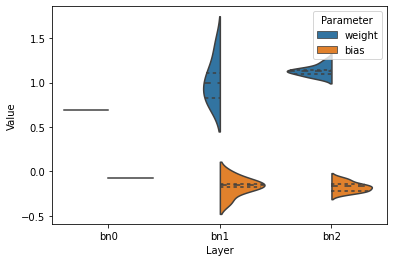

In [24]:
create_violin_plots(bn_params)

## Problem 1
### Question 4
<span style="color:blue">Train the network without batch normalization but this time use dropout</span>

> Train model for 10 epochs using Adam optimizer, add has_dropout=True while creating the model so that the dropout layers are created and included

In [25]:
model_config = ModelConfig()
model_q4 = LeNet5(has_dropout=True).to(device)
optimizer = model_config.optimizer(model_q4.parameters(), lr=model_config.learning_rate)
criterion = model_config.criterion()
    
best_accuracy = 0.0
for epoch in range(1,model_config.num_epochs+1):
    print(f"Epoch: ({epoch}/{model_config.num_epochs})")

    training_correct, training_loss, _ = train(data_loader = train_loader_post_normalize, model=model_q4, criterion=criterion, optimizer=optimizer)
    training_loss = training_loss/num_batches
    training_accuracy = training_correct/num_samples
    print(f"Training Accuracy: {training_accuracy * 100:.2f}%, Training Loss: {training_loss}")

    validation_correct, validation_loss = evaluate(data_loader = train_loader_post_normalize, model=model_q4, criterion=criterion)
    validation_loss = validation_loss/num_batches
    validation_accuracy = validation_correct/num_samples
    print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%, Validation Loss: {validation_loss}")

    test_correct, test_loss = evaluate(data_loader = test_loader_post_normalize, model=model_q4, criterion=criterion)
    test_loss = test_loss/len(test_loader_post_normalize)
    test_accuracy = test_correct/len(test_loader_post_normalize.dataset)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model_q4.state_dict(), "model_q4.pt")

print(f"\n\nBest Test Accuracy: {best_accuracy * 100:.2f}%")

Epoch: (1/10)


938it [00:12, 74.78it/s]


Training Accuracy: 74.57%, Training Loss: 0.706443956951851
Validation Accuracy: 97.14%, Validation Loss: 0.10361708193493169
Test Accuracy: 97.39%, Test Loss: 0.09395724905144637
Epoch: (2/10)


938it [00:12, 74.35it/s]


Training Accuracy: 78.88%, Training Loss: 0.5669966541977325
Validation Accuracy: 98.11%, Validation Loss: 0.07153918534747637
Test Accuracy: 98.14%, Test Loss: 0.06861303396712823
Epoch: (3/10)


938it [00:12, 74.69it/s]


Training Accuracy: 79.47%, Training Loss: 0.5492089830958513
Validation Accuracy: 98.44%, Validation Loss: 0.055915707481036116
Test Accuracy: 98.48%, Test Loss: 0.05031643354683925
Epoch: (4/10)


938it [00:12, 74.55it/s]


Training Accuracy: 79.68%, Training Loss: 0.5420286856385182
Validation Accuracy: 98.72%, Validation Loss: 0.049719914510997054
Test Accuracy: 98.72%, Test Loss: 0.04714171643291784
Epoch: (5/10)


938it [00:12, 74.56it/s]


Training Accuracy: 80.14%, Training Loss: 0.5272525796758086
Validation Accuracy: 98.95%, Validation Loss: 0.041947689847643375
Test Accuracy: 98.92%, Test Loss: 0.040396552405373494
Epoch: (6/10)


938it [00:12, 74.11it/s]


Training Accuracy: 80.27%, Training Loss: 0.5181908504382126
Validation Accuracy: 99.01%, Validation Loss: 0.03795950975902537
Test Accuracy: 98.93%, Test Loss: 0.03717548094517818
Epoch: (7/10)


938it [00:12, 75.45it/s]


Training Accuracy: 80.37%, Training Loss: 0.5203123685361734
Validation Accuracy: 98.95%, Validation Loss: 0.042027049349682495
Test Accuracy: 99.02%, Test Loss: 0.04032179667276277
Epoch: (8/10)


938it [00:12, 75.14it/s]


Training Accuracy: 80.36%, Training Loss: 0.5200373992355648
Validation Accuracy: 99.23%, Validation Loss: 0.033373269143758585
Test Accuracy: 99.19%, Test Loss: 0.03494665663908859
Epoch: (9/10)


938it [00:12, 74.67it/s]


Training Accuracy: 80.46%, Training Loss: 0.516831392910816
Validation Accuracy: 99.20%, Validation Loss: 0.03507284211840774
Test Accuracy: 99.14%, Test Loss: 0.03596376079864278
Epoch: (10/10)


938it [00:12, 74.54it/s]


Training Accuracy: 80.50%, Training Loss: 0.5168115777660535
Validation Accuracy: 99.14%, Validation Loss: 0.03420154519775299
Test Accuracy: 99.11%, Test Loss: 0.03694250567217067


Best Test Accuracy: 99.19%


<span style="color:blue">Compare test accuracy using dropout to test accuracy obtained using batch normalization in parts 2 and 3</span>

|  | Test Accuracy (%) |
| --------------- | --------------- |
| Dropout | 99.19|
| Standard Normalization | 99.07 |
| Batch Normalization | 99.07 | 

*Performance using dropout is an improvement over not using dropout.*

## Problem 1
### Question 5
<span style="color:blue">Now train the network using both batch normalization and dropout.</span>

> Train model for  10 epochs using Adam optimizer, add has_dropout=True and has_input_batch_norm=True

In [26]:
model_config = ModelConfig()
model_q5 = LeNet5(has_input_batch_norm=True, has_dropout=True).to(device)
optimizer = model_config.optimizer(model_q5.parameters(), lr=model_config.learning_rate)
criterion = model_config.criterion()
    
best_accuracy = 0.0
for epoch in range(1,model_config.num_epochs+1):
    print(f"Epoch: ({epoch}/{model_config.num_epochs})")

    training_correct, training_loss, _ = train(data_loader = train_loader_pre_normalize, model=model_q5, criterion=criterion, optimizer=optimizer)
    training_loss = training_loss/num_batches
    training_accuracy = training_correct/num_samples
    print(f"Training Accuracy: {training_accuracy * 100:.2f}%, Training Loss: {training_loss}")

    validation_correct, validation_loss = evaluate(data_loader = train_loader_pre_normalize, model=model_q5, criterion=criterion)
    validation_loss = validation_loss/num_batches
    validation_accuracy = validation_correct/num_samples
    print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%, Validation Loss: {validation_loss}")

    test_correct, test_loss = evaluate(data_loader = test_loader_pre_normalize, model=model_q5, criterion=criterion)
    test_loss = test_loss/len(test_loader_pre_normalize)
    test_accuracy = test_correct/len(test_loader_pre_normalize.dataset)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss}")
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model_q5.state_dict(), "model_q5.pt")

print(f"\n\nBest Test Accuracy: {best_accuracy * 100:.2f}%")

Epoch: (1/10)


938it [00:07, 124.89it/s]


Training Accuracy: 73.89%, Training Loss: 0.7183171374075956
Validation Accuracy: 97.75%, Validation Loss: 0.09200607391515139
Test Accuracy: 97.90%, Test Loss: 0.08349796956416908
Epoch: (2/10)


938it [00:07, 125.83it/s]


Training Accuracy: 79.09%, Training Loss: 0.561511052410994
Validation Accuracy: 98.33%, Validation Loss: 0.06642228511791588
Test Accuracy: 98.33%, Test Loss: 0.06203597849294259
Epoch: (3/10)


938it [00:07, 125.55it/s]


Training Accuracy: 79.26%, Training Loss: 0.5521450602868473
Validation Accuracy: 98.53%, Validation Loss: 0.05686014005963975
Test Accuracy: 98.52%, Test Loss: 0.05368099721729945
Epoch: (4/10)


938it [00:07, 126.24it/s]


Training Accuracy: 79.95%, Training Loss: 0.5326844135771936
Validation Accuracy: 98.85%, Validation Loss: 0.04411330553707975
Test Accuracy: 98.70%, Test Loss: 0.043105250182947155
Epoch: (5/10)


938it [00:07, 126.09it/s]


Training Accuracy: 79.80%, Training Loss: 0.5332058650661887
Validation Accuracy: 98.86%, Validation Loss: 0.04520181864539761
Test Accuracy: 98.78%, Test Loss: 0.04406182327942484
Epoch: (6/10)


938it [00:07, 125.43it/s]


Training Accuracy: 80.27%, Training Loss: 0.5230348032039366
Validation Accuracy: 99.03%, Validation Loss: 0.0407843735398673
Test Accuracy: 98.94%, Test Loss: 0.041275620777871766
Epoch: (7/10)


938it [00:07, 126.91it/s]


Training Accuracy: 80.43%, Training Loss: 0.5171065539248717
Validation Accuracy: 99.08%, Validation Loss: 0.03513264234340601
Test Accuracy: 99.10%, Test Loss: 0.035370614530910165
Epoch: (8/10)


938it [00:07, 125.86it/s]


Training Accuracy: 80.25%, Training Loss: 0.5192481605355928
Validation Accuracy: 99.15%, Validation Loss: 0.03343900344096251
Test Accuracy: 99.08%, Test Loss: 0.033922644309806314
Epoch: (9/10)


938it [00:07, 126.32it/s]


Training Accuracy: 80.60%, Training Loss: 0.5116056121075585
Validation Accuracy: 99.06%, Validation Loss: 0.0355201619155983
Test Accuracy: 98.79%, Test Loss: 0.04126750652909659
Epoch: (10/10)


938it [00:07, 125.81it/s]


Training Accuracy: 80.72%, Training Loss: 0.5106927934231789
Validation Accuracy: 99.30%, Validation Loss: 0.030734814748144164
Test Accuracy: 99.22%, Test Loss: 0.03509265894758379


Best Test Accuracy: 99.22%


<span style="color:blue">How does the performance (test accuracy) of the network compare with the cases with dropout alone and with batch normalization alone?</span>

|  | Test Accuracy (%) |
| --------------- | --------------- |
| Dropout and batch norm | 99.22|
| Dropout | 99.19|
| Standard Normalization | 99.07 |
| Batch Normalization | 99.07 | 

*Performance using both dropout and batch norm beats all other choices.*

## Problem 2
### Question 1

> Define the MiniGoogLeNet architecture, using Yuanzhe Liu's [implementation](https://github.com/ggflow123/MiniGoogLeNet-PyTorch/blob/main/MiniGoogLeNet.ipynb)

In [14]:
class ConvModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride, padding='same'):
        super(ConvModule, self).__init__()
        self.conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=stride, padding=padding)

        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
  
    def forward(self, x):
        x = self.conv2d(x)
        x = self.batchnorm(x)
        x = self.relu(x)

        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3):
        super(InceptionModule, self).__init__()

        self.conv1x1 = ConvModule(in_channels, ch1x1, (1, 1), 1)
        self.conv3x3 = ConvModule(in_channels, ch3x3, (3, 3), 1)

    def forward(self, x):
        out1 = self.conv1x1(x)
        out2 = self.conv3x3(x)
        x = torch.cat((out1, out2), 1)
        return x

class DownsampleModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownsampleModule, self).__init__()

        self.conv3x3 = ConvModule(in_channels, out_channels, (3, 3), (2, 2), padding='valid')
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        out1 = self.conv3x3(x)
        out2 = self.maxpool(x)
        x = torch.cat((out1, out2), 1)
        return x
    

class MiniGoogLeNet(nn.Module):
    def __init__(self, classes, input_channels):
        super(MiniGoogLeNet, self).__init__()

        self.conv1 = ConvModule(input_channels, 96, kernel_size=(3, 3), stride=1)
        self.inception1 = InceptionModule(96, 32, 32)
        self.inception2 = InceptionModule(32+32, 32, 48)
        self.downsample1 = DownsampleModule(32+48, 80)

        self.inception3 = InceptionModule(80+80, 112, 48)
        self.inception4 = InceptionModule(112+48, 96, 64)
        self.inception5 = InceptionModule(96+64, 80, 80)
        self.inception6 = InceptionModule(80+80, 48, 96)
        self.downsample2 = DownsampleModule(48+96, 96)

        self.inception7 = InceptionModule(96+96, 176, 160)
        self.inception8 = InceptionModule(176+160, 176, 160)
        self.avgpool2d = nn.AvgPool2d(kernel_size=7)
        self.dropout = nn.Dropout2d(0.5)

        self.fc = nn.Linear(240, classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.downsample1(x)

        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.downsample2(x)

        x = self.avgpool2d(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

> Create data loaders for the Fashion MNIST dataset with batch size = 64

In [15]:
batchSize = 64

transformations = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                               ])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transformations)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transformations)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False)

<span style="color:blue">Train MiniGoogleNet model on Fashion MNIST for 5 epochs, for 10 candidate learning rates</span>

In [17]:
epochs = 5
learning_rates = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

lr_to_loss = {}
torch.cuda.empty_cache()
for lr in learning_rates:
    print(f"Learning Rate: {lr}")
    model = MiniGoogLeNet(classes=10, input_channels=1)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)

    avg_training_loss = 0.0
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        correct, loss, _ = train(trainloader, model, criterion, optimizer)
        accuracy = correct / len(trainloader.dataset)
        loss = loss / len(trainloader)
        print(f"Accuracy: {accuracy*100:.2f}%, Loss: {loss}")
        avg_training_loss += loss
    avg_training_loss /=epochs
    lr_to_loss[lr] = avg_training_loss

Learning Rate: 1e-09
Epoch: 1/5


938it [00:28, 32.99it/s]


Accuracy: 9.71%, Loss: 2.6025469104872583
Epoch: 2/5


938it [00:15, 61.40it/s]


Accuracy: 10.01%, Loss: 2.5962826829475127
Epoch: 3/5


938it [00:15, 61.55it/s]


Accuracy: 9.69%, Loss: 2.595870749020119
Epoch: 4/5


938it [00:15, 61.86it/s]


Accuracy: 9.94%, Loss: 2.59626322921151
Epoch: 5/5


938it [00:15, 61.56it/s]


Accuracy: 9.66%, Loss: 2.596948854450478
Learning Rate: 1e-08
Epoch: 1/5


938it [00:15, 61.78it/s]


Accuracy: 11.30%, Loss: 2.65320420976895
Epoch: 2/5


938it [00:15, 61.58it/s]


Accuracy: 11.19%, Loss: 2.651765913088947
Epoch: 3/5


938it [00:15, 61.86it/s]


Accuracy: 11.29%, Loss: 2.65548866923684
Epoch: 4/5


938it [00:15, 61.56it/s]


Accuracy: 11.42%, Loss: 2.6465080302915593
Epoch: 5/5


938it [00:15, 61.45it/s]


Accuracy: 11.45%, Loss: 2.645583294093736
Learning Rate: 1e-07
Epoch: 1/5


938it [00:15, 61.66it/s]


Accuracy: 9.63%, Loss: 2.572595228010149
Epoch: 2/5


938it [00:15, 61.58it/s]


Accuracy: 9.71%, Loss: 2.555258371936741
Epoch: 3/5


938it [00:15, 61.80it/s]


Accuracy: 10.16%, Loss: 2.5478400810440975
Epoch: 4/5


938it [00:15, 61.48it/s]


Accuracy: 10.28%, Loss: 2.5332966824330247
Epoch: 5/5


938it [00:15, 61.71it/s]


Accuracy: 10.45%, Loss: 2.5221794787754637
Learning Rate: 1e-06
Epoch: 1/5


938it [00:15, 61.65it/s]


Accuracy: 11.16%, Loss: 2.526644197100007
Epoch: 2/5


938it [00:15, 61.85it/s]


Accuracy: 12.32%, Loss: 2.445014016460508
Epoch: 3/5


938it [00:15, 61.82it/s]


Accuracy: 13.78%, Loss: 2.3736691833304953
Epoch: 4/5


938it [00:15, 61.63it/s]


Accuracy: 15.37%, Loss: 2.316500107616758
Epoch: 5/5


938it [00:15, 61.70it/s]


Accuracy: 16.63%, Loss: 2.2678837544882477
Learning Rate: 1e-05
Epoch: 1/5


938it [00:15, 61.60it/s]


Accuracy: 18.15%, Loss: 2.273366962795827
Epoch: 2/5


938it [00:15, 61.77it/s]


Accuracy: 32.22%, Loss: 1.9506712586386625
Epoch: 3/5


938it [00:15, 61.60it/s]


Accuracy: 39.96%, Loss: 1.752293337128564
Epoch: 4/5


938it [00:15, 61.69it/s]


Accuracy: 44.79%, Loss: 1.6088721829690913
Epoch: 5/5


938it [00:15, 61.83it/s]


Accuracy: 48.54%, Loss: 1.4999012251906811
Learning Rate: 0.0001
Epoch: 1/5


938it [00:15, 61.49it/s]


Accuracy: 46.16%, Loss: 1.5557100842756504
Epoch: 2/5


938it [00:15, 61.89it/s]


Accuracy: 67.07%, Loss: 0.9921093081106255
Epoch: 3/5


938it [00:15, 61.57it/s]


Accuracy: 73.42%, Loss: 0.7895449037745055
Epoch: 4/5


938it [00:15, 61.55it/s]


Accuracy: 76.20%, Loss: 0.6867277070975253
Epoch: 5/5


938it [00:15, 61.60it/s]


Accuracy: 78.11%, Loss: 0.6248980277001477
Learning Rate: 0.001
Epoch: 1/5


938it [00:15, 61.45it/s]


Accuracy: 71.91%, Loss: 0.8035595242593334
Epoch: 2/5


938it [00:15, 61.86it/s]


Accuracy: 84.46%, Loss: 0.4437459955242143
Epoch: 3/5


938it [00:15, 61.66it/s]


Accuracy: 87.09%, Loss: 0.37111392636288965
Epoch: 4/5


938it [00:15, 61.57it/s]


Accuracy: 88.65%, Loss: 0.32406197495456696
Epoch: 5/5


938it [00:15, 61.55it/s]


Accuracy: 89.60%, Loss: 0.2961281360641344
Learning Rate: 0.01
Epoch: 1/5


938it [00:15, 61.69it/s]


Accuracy: 79.66%, Loss: 0.5577627612647217
Epoch: 2/5


938it [00:15, 61.46it/s]


Accuracy: 87.83%, Loss: 0.34317722532953787
Epoch: 3/5


938it [00:15, 61.76it/s]


Accuracy: 89.62%, Loss: 0.2919402660242022
Epoch: 4/5


938it [00:15, 61.69it/s]


Accuracy: 90.72%, Loss: 0.25899417818323384
Epoch: 5/5


938it [00:15, 61.59it/s]


Accuracy: 91.52%, Loss: 0.237293399524873
Learning Rate: 0.1
Epoch: 1/5


938it [00:15, 61.67it/s]


Accuracy: 76.95%, Loss: 0.6373370362878609
Epoch: 2/5


938it [00:15, 61.56it/s]


Accuracy: 86.62%, Loss: 0.3746704700182496
Epoch: 3/5


938it [00:15, 61.50it/s]


Accuracy: 88.81%, Loss: 0.312426071606084
Epoch: 4/5


938it [00:15, 61.57it/s]


Accuracy: 90.05%, Loss: 0.283761830551665
Epoch: 5/5


938it [00:15, 61.67it/s]


Accuracy: 90.59%, Loss: 0.26051428041923275
Learning Rate: 1
Epoch: 1/5


938it [00:15, 61.57it/s]


Accuracy: 32.16%, Loss: 1.7738440398976747
Epoch: 2/5


938it [00:15, 61.65it/s]


Accuracy: 50.46%, Loss: 1.270680497323018
Epoch: 3/5


938it [00:15, 61.64it/s]


Accuracy: 64.18%, Loss: 0.9893680591700174
Epoch: 4/5


938it [00:15, 61.74it/s]


Accuracy: 69.99%, Loss: 0.8520805603786826
Epoch: 5/5


938it [00:15, 61.63it/s]

Accuracy: 71.89%, Loss: 0.8134413766644911


<span style="color:blue">Plot the training loss as a function of the learning rate</span>

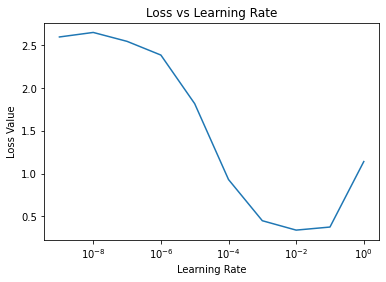

In [18]:
def plot_losses(losses):
    plt.plot(list(losses.keys()), list(losses.values()))
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss Value')
    plt.title('Loss vs Learning Rate')
    plt.show()

plot_losses(lr_to_loss)

<span style="color:blue">From that figure identify the values of lr_min and lr_max.</span> 
<br /><br />
*We identify lr_min and lr_max as 7*1e-5 and 1e-2 respectively. These min and max values best capture the loss slope in the graph.*

## Problem 2
### Question 2
<span style="color:blue"> Use the cyclical learning rate policy (with exponential decay) and train your network using batch size
64 and lrmin and lrmax values</span>

In [19]:
lr_min = 7*1e-5
lr_max = 1e-2
epochs = 30
step_size = (len(trainset)/batchSize) // 2

model = MiniGoogLeNet(classes=10, input_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_min, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
lr_tracker = {}

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    correct, loss, rate_tracker = train(data_loader=trainloader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
    accuracy = correct / len(trainloader.dataset)
    loss = loss / len(trainloader)
    train_acc_history.append(accuracy)
    train_loss_history.append(loss)
    for key in rate_tracker.keys():
        lr_tracker[(epoch,key)] = rate_tracker[key]

    correct, loss = evaluate(data_loader = testloader, model=model, criterion=criterion)
    validation_accuracy = correct / len(testloader.dataset)
    validation_loss = loss / len(testloader)
    val_acc_history.append(validation_accuracy)
    val_loss_history.append(validation_loss)
    

Epoch: 1/30


938it [00:15, 61.75it/s]


Epoch: 2/30


938it [00:15, 61.72it/s]


Epoch: 3/30


938it [00:15, 61.65it/s]


Epoch: 4/30


938it [00:15, 61.90it/s]


Epoch: 5/30


938it [00:15, 61.69it/s]


Epoch: 6/30


938it [00:15, 61.57it/s]


Epoch: 7/30


938it [00:15, 61.46it/s]


Epoch: 8/30


938it [00:15, 61.78it/s]


Epoch: 9/30


938it [00:15, 61.53it/s]


Epoch: 10/30


938it [00:15, 61.81it/s]


Epoch: 11/30


938it [00:15, 61.80it/s]


Epoch: 12/30


938it [00:15, 61.80it/s]


Epoch: 13/30


938it [00:15, 61.54it/s]


Epoch: 14/30


938it [00:15, 61.53it/s]


Epoch: 15/30


938it [00:15, 61.56it/s]


Epoch: 16/30


938it [00:15, 61.67it/s]


Epoch: 17/30


938it [00:15, 61.73it/s]


Epoch: 18/30


938it [00:15, 61.99it/s]


Epoch: 19/30


938it [00:15, 61.86it/s]


Epoch: 20/30


938it [00:15, 61.65it/s]


Epoch: 21/30


938it [00:15, 61.65it/s]


Epoch: 22/30


938it [00:15, 61.63it/s]


Epoch: 23/30


938it [00:15, 61.98it/s]


Epoch: 24/30


938it [00:15, 61.95it/s]


Epoch: 25/30


938it [00:15, 61.81it/s]


Epoch: 26/30


938it [00:15, 61.65it/s]


Epoch: 27/30


938it [00:15, 61.89it/s]


Epoch: 28/30


938it [00:15, 61.56it/s]


Epoch: 29/30


938it [00:15, 61.77it/s]


Epoch: 30/30


938it [00:15, 61.86it/s]


<span style="color:blue">Plot train/validation loss and accuracy curve</span>

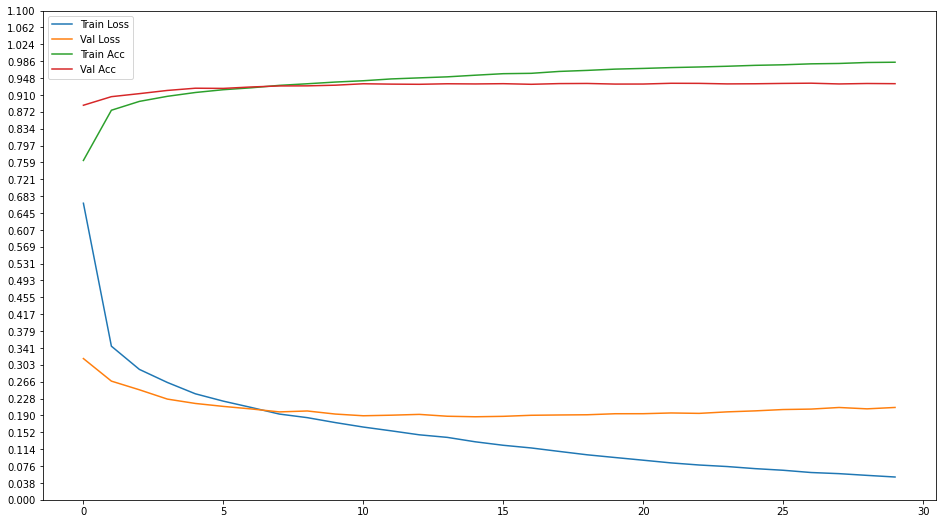

In [20]:
fig, ax = plt.subplots(figsize=(16,9))

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.plot(train_acc_history, label='Train Acc')  
plt.plot(val_acc_history, label='Val Acc')
plt.legend()

yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.show()    

> We also plot the learning rate over batches to ensure that a sensible triangular policy with exponential decay was followed.

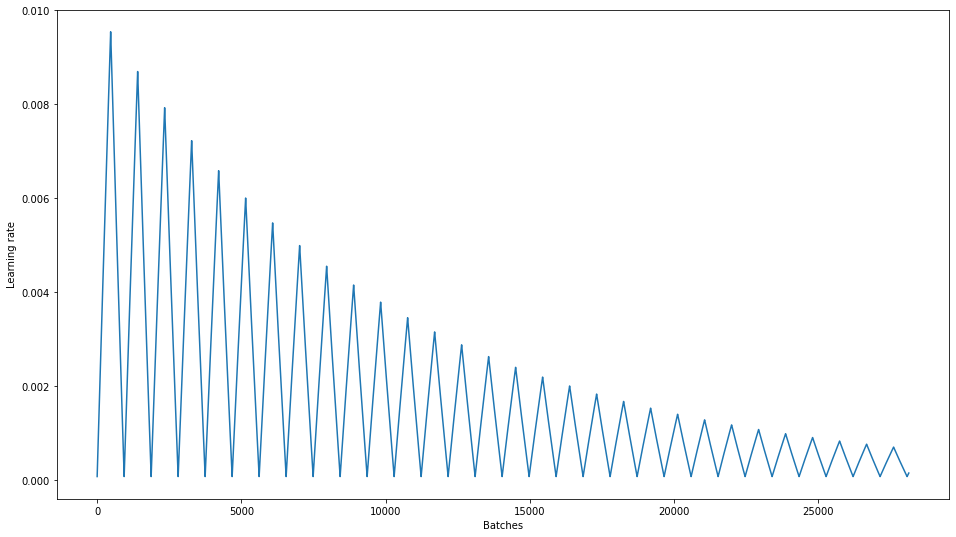

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(range(len(lr_tracker)), lr_tracker.values())
plt.xlabel('Batches')
plt.ylabel('Learning rate')
plt.show()

## Problem 2
### Question 3
<span style="color:blue"> Fix learning rate to lrmax and train your network starting with batch size 32 and incrementally going up to 16384</span>

In [22]:
epochs = 10
lr = lr_max
batch_sizes = [2 ** i for i in range(6, 13)]
batch_size_to_loss = {}

for batchSize in batch_sizes:
    print(f"Batch Size: {batchSize}")
    torch.cuda.empty_cache()
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True)
    model = MiniGoogLeNet(classes=10, input_channels=1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    avg_training_loss = 0.0
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        correct, loss, _ = train(trainloader, model, criterion, optimizer)
        accuracy = correct / len(trainloader.dataset)
        print(f"Accuracy: {accuracy*100:.2f}%, Loss: {loss}")
        avg_training_loss += loss
    avg_training_loss /=epochs
    batch_size_to_loss[batchSize] = avg_training_loss
    

Batch Size: 64
Epoch: 1/10


938it [00:15, 61.51it/s]


Accuracy: 71.94%, Loss: 748.5780564844608
Epoch: 2/10


938it [00:15, 61.44it/s]


Accuracy: 84.32%, Loss: 416.39217875897884
Epoch: 3/10


938it [00:15, 61.48it/s]


Accuracy: 87.10%, Loss: 344.2504647374153
Epoch: 4/10


938it [00:15, 61.69it/s]


Accuracy: 88.59%, Loss: 305.09863030165434
Epoch: 5/10


938it [00:15, 61.85it/s]


Accuracy: 89.60%, Loss: 279.24126091599464
Epoch: 6/10


938it [00:15, 61.89it/s]


Accuracy: 90.24%, Loss: 259.7822047472
Epoch: 7/10


938it [00:15, 61.87it/s]


Accuracy: 90.92%, Loss: 241.7390864044428
Epoch: 8/10


938it [00:15, 61.85it/s]


Accuracy: 91.45%, Loss: 229.23923230543733
Epoch: 9/10


938it [00:15, 61.84it/s]


Accuracy: 91.93%, Loss: 216.33278835564852
Epoch: 10/10


938it [00:15, 61.92it/s]


Accuracy: 92.21%, Loss: 208.34039226546884
Batch Size: 128
Epoch: 1/10


469it [00:16, 28.21it/s]


Accuracy: 65.93%, Loss: 466.57395973801613
Epoch: 2/10


469it [00:16, 28.48it/s]


Accuracy: 81.13%, Loss: 250.72850078344345
Epoch: 3/10


469it [00:16, 28.44it/s]


Accuracy: 84.64%, Loss: 204.79970413446426
Epoch: 4/10


469it [00:16, 28.44it/s]


Accuracy: 86.59%, Loss: 179.07408536970615
Epoch: 5/10


469it [00:16, 28.49it/s]


Accuracy: 88.01%, Loss: 161.75325867533684
Epoch: 6/10


469it [00:16, 28.47it/s]


Accuracy: 89.02%, Loss: 148.66709192097187
Epoch: 7/10


469it [00:16, 28.49it/s]


Accuracy: 89.65%, Loss: 138.89624394476414
Epoch: 8/10


469it [00:16, 28.51it/s]


Accuracy: 90.23%, Loss: 130.0508160442114
Epoch: 9/10


469it [00:16, 28.51it/s]


Accuracy: 90.69%, Loss: 125.17522965371609
Epoch: 10/10


469it [00:16, 28.51it/s]


Accuracy: 91.25%, Loss: 118.23434920608997
Batch Size: 256
Epoch: 1/10


235it [00:16, 14.23it/s]


Accuracy: 57.31%, Loss: 291.1356640458107
Epoch: 2/10


235it [00:16, 14.30it/s]


Accuracy: 76.34%, Loss: 160.98436987400055
Epoch: 3/10


235it [00:16, 14.30it/s]


Accuracy: 80.13%, Loss: 131.3977796435356
Epoch: 4/10


235it [00:16, 14.30it/s]


Accuracy: 83.10%, Loss: 112.8212902545929
Epoch: 5/10


235it [00:16, 14.31it/s]


Accuracy: 85.23%, Loss: 99.54396307468414
Epoch: 6/10


235it [00:16, 14.31it/s]


Accuracy: 86.56%, Loss: 90.58743068575859
Epoch: 7/10


235it [00:16, 14.32it/s]


Accuracy: 87.44%, Loss: 84.96278017759323
Epoch: 8/10


235it [00:16, 14.31it/s]


Accuracy: 88.33%, Loss: 79.0063049942255
Epoch: 9/10


235it [00:16, 14.31it/s]


Accuracy: 88.93%, Loss: 74.83451199531555
Epoch: 10/10


235it [00:16, 14.31it/s]


Accuracy: 89.50%, Loss: 71.11046040058136
Batch Size: 512
Epoch: 1/10


118it [00:16,  7.18it/s]


Accuracy: 46.10%, Loss: 183.33414697647095
Epoch: 2/10


118it [00:16,  7.23it/s]


Accuracy: 69.80%, Loss: 108.3418561220169
Epoch: 3/10


118it [00:16,  7.28it/s]


Accuracy: 76.01%, Loss: 83.87119376659393
Epoch: 4/10


118it [00:16,  7.28it/s]


Accuracy: 78.81%, Loss: 72.3946802020073
Epoch: 5/10


118it [00:16,  7.28it/s]


Accuracy: 80.35%, Loss: 65.5068137049675
Epoch: 6/10


118it [00:16,  7.28it/s]


Accuracy: 82.45%, Loss: 59.48237094283104
Epoch: 7/10


118it [00:16,  7.24it/s]


Accuracy: 83.50%, Loss: 55.56421813368797
Epoch: 8/10


118it [00:16,  7.28it/s]


Accuracy: 84.73%, Loss: 51.6252661049366
Epoch: 9/10


118it [00:16,  7.29it/s]


Accuracy: 85.70%, Loss: 48.55219063162804
Epoch: 10/10


118it [00:16,  7.29it/s]


Accuracy: 86.41%, Loss: 46.31296482682228
Batch Size: 1024
Epoch: 1/10


59it [00:16,  3.63it/s]


Accuracy: 35.30%, Loss: 109.00406849384308
Epoch: 2/10


59it [00:16,  3.66it/s]


Accuracy: 59.76%, Loss: 71.40752863883972
Epoch: 3/10


59it [00:16,  3.66it/s]


Accuracy: 68.19%, Loss: 57.07530105113983
Epoch: 4/10


59it [00:16,  3.64it/s]


Accuracy: 71.92%, Loss: 48.81178867816925
Epoch: 5/10


59it [00:16,  3.65it/s]


Accuracy: 74.56%, Loss: 43.57684922218323
Epoch: 6/10


59it [00:16,  3.65it/s]


Accuracy: 76.19%, Loss: 40.04596304893494
Epoch: 7/10


59it [00:16,  3.64it/s]


Accuracy: 77.72%, Loss: 37.25038832426071
Epoch: 8/10


59it [00:16,  3.66it/s]


Accuracy: 78.89%, Loss: 35.21766436100006
Epoch: 9/10


59it [00:16,  3.66it/s]


Accuracy: 79.83%, Loss: 33.393525421619415
Epoch: 10/10


59it [00:16,  3.65it/s]


Accuracy: 81.15%, Loss: 31.697769939899445
Batch Size: 2048
Epoch: 1/10


30it [00:16,  1.83it/s]


Accuracy: 21.86%, Loss: 65.42585098743439
Epoch: 2/10


30it [00:16,  1.83it/s]


Accuracy: 44.55%, Loss: 48.33136284351349
Epoch: 3/10


30it [00:16,  1.83it/s]


Accuracy: 54.93%, Loss: 39.95374846458435
Epoch: 4/10


30it [00:16,  1.83it/s]


Accuracy: 61.85%, Loss: 34.76951336860657
Epoch: 5/10


30it [00:16,  1.83it/s]


Accuracy: 66.48%, Loss: 30.919951736927032
Epoch: 6/10


30it [00:16,  1.83it/s]


Accuracy: 69.32%, Loss: 28.050115764141083
Epoch: 7/10


30it [00:16,  1.83it/s]


Accuracy: 71.67%, Loss: 25.826418459415436
Epoch: 8/10


30it [00:16,  1.83it/s]


Accuracy: 73.31%, Loss: 24.082307994365692
Epoch: 9/10


30it [00:16,  1.83it/s]


Accuracy: 74.85%, Loss: 22.474709689617157
Epoch: 10/10


30it [00:16,  1.83it/s]


Accuracy: 75.94%, Loss: 21.388391137123108
Batch Size: 4096
Epoch: 1/10


15it [00:16,  1.11s/it]


Accuracy: 13.75%, Loss: 35.36027455329895
Epoch: 2/10


15it [00:16,  1.11s/it]


Accuracy: 28.02%, Loss: 30.108109831809998
Epoch: 3/10


15it [00:16,  1.11s/it]


Accuracy: 38.38%, Loss: 25.950305819511414
Epoch: 4/10


15it [00:16,  1.11s/it]


Accuracy: 44.47%, Loss: 23.106629252433777
Epoch: 5/10


15it [00:16,  1.11s/it]


Accuracy: 49.16%, Loss: 21.147852301597595
Epoch: 6/10


15it [00:16,  1.11s/it]


Accuracy: 53.41%, Loss: 19.711111426353455
Epoch: 7/10


15it [00:16,  1.11s/it]


Accuracy: 57.34%, Loss: 18.440840363502502
Epoch: 8/10


15it [00:16,  1.11s/it]


Accuracy: 60.07%, Loss: 17.39946961402893
Epoch: 9/10


15it [00:16,  1.11s/it]


Accuracy: 62.99%, Loss: 16.48322904109955
Epoch: 10/10


15it [00:16,  1.11s/it]

Accuracy: 65.04%, Loss: 15.637502193450928


<span style="color:blue">Plot the training loss.</span>

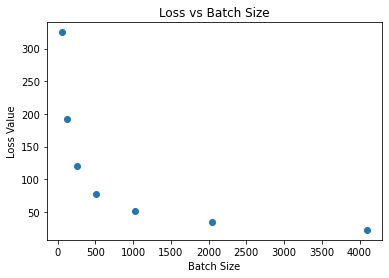

In [25]:
def plot_losses_batch_version(losses):
    plt.scatter(list(losses.keys()), list(losses.values()))
    plt.xlabel('Batch Size')
    plt.ylabel('Loss Value')
    plt.title('Loss vs Batch Size')
    plt.show()

plot_losses_batch_version(batch_size_to_loss)

<span style="color:blue"> Is the generalization of your final model similar or different from than cyclical learning rate policy?</span><br /><br />
*Answer here*

## Problem 3
### Question 1
<span style="color:blue"> Calculate the number of parameters in Alexnet. You will have to show calculations for each layer and
then sum it to obtain the total number of parameters in Alexnet. When calculating you will need to
account for all the filters (size, strides, padding) at each layer.</span>

## Problem 3
### Question 2
<span style="color:blue"> VGG (Simonyan et al.) has an extremely homogeneous architecture that only performs 3x3 convolutions
with stride 1 and pad 1 and 2x2 max pooling with stride 2 (and no padding) from the beginning to
the end. However VGGNet is very expensive to evaluate and uses a lot more memory and parameters. Calculate number of activations and parameters per layer, show your calculations. </span>

## Problem 3
### Question 3
<span style="color:blue">VGG architectures have smaller filters but deeper networks compared to Alexnet (3x3 compared to
11x11 or 5x5). Show that a stack of N convolution layers each of filter size F × F has the same
receptive field as one convolution layer with filter of size (NF − N + 1) × (NF − N + 1). Use this to
calculate the receptive field of 3 filters of size 5x5. </span>

## Problem 3
### Question 4